In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "QzpcVXNlcnNcTmlrb2xhalxEcm9wYm94XEdpdFxncmFwaC1lcXVpbGlicml1bS1yYWRpYXRpdmUtdHJhbnNmZXJcY2hhcHRlcnM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| label: env
#| include: false

import Pkg

# Activate the book project
Pkg.activate(abspath(joinpath(@__DIR__, "..")))  # adjust if your cell lives deeper

if get(ENV, "CI", "false") == "true"
    # --- CI on GitHub Pages: use newest *registered* version within [compat] ---
    # Keep RayTraceHeatTransfer in [deps] with a [compat] like: RayTraceHeatTransfer = "0.3"
    Pkg.instantiate()
    Pkg.update("RayTraceHeatTransfer")   # float to latest allowed version
else
    # --- Local dev: always track the latest main branch ---
    url = "https://github.com/NikoBiele/RayTraceHeatTransfer.jl"
    try
        Pkg.rm("RayTraceHeatTransfer"; force=true)
    catch
    end
    Pkg.add(Pkg.PackageSpec(name="RayTraceHeatTransfer", url=url, rev="main"))
    Pkg.instantiate()
end

using CairoMakie
CairoMakie.activate!()
Makie.inline!(true)

using RayTraceHeatTransfer


  Activating project at `C:\Users\Nikolaj\Dropbox\Git\graph-equilibrium-radiative-transfer`


    Updating git-repo `https://github.com/NikoBiele/RayTraceHeatTransfer.jl`


   Resolving

 package versions...


  No Changes to `C:\Users\Nikolaj\Dropbox\Git\graph-equilibrium-radiative-transfer\Project.toml`
  No Changes to `C:\Users\Nikolaj\Dropbox\Git\graph-equilibrium-radiative-transfer\Manifest.toml`


In [3]:
using RayTraceHeatTransfer
using StaticArrays
using GeometryBasics
# build the geometric quadrilateral face (4 points)
faces_1 = RayTraceHeatTransfer.PolyFace2D{Float64,Float64}[]
vertices1 = SVector(
    Point2(0.0, 0.0),
    Point2(1.0, 0.0),
    Point2(1.0, 1.0),
    Point2(0.0, 1.0),
)

4-element SVector{4, Point{2, Float64}} with indices SOneTo(4):
 [0.0, 0.0]
 [1.0, 0.0]
 [1.0, 1.0]
 [0.0, 1.0]

In [4]:
solidWall1 = SVector(true, true, true, true) # all walls are impenetrable
face1 = RayTraceHeatTransfer.PolyFace2D{Float64,Float64}(vertices1, solidWall1)

# set the physical properties and state
face1.T_in_w = [1000.0, 0.0, 0.0, 0.0] # known wall temperatures
face1.q_in_w = [0.0, 0.0, 0.0, 0.0] # wall fluxes not used when temperature is specified
face1.T_in_g = -1.0 # unknown gas temperature
face1.q_in_g = 0.0 # known gas flux (radiative equilibrium)
face1.epsilon = [1.0, 1.0, 1.0, 1.0] # wall emissivities
push!(faces_1, face1)

1-element Vector{PolyFace2D{Float64, Float64}}:
 PolyFace2D{Float64, Float64}(Point{2, Float64}[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]], Bool[1, 1, 1, 1], [0.5, 0.5], Point{2, Float64}[[0.5, 0.0], [1.0, 0.5], [0.5, 1.0], [0.0, 0.5]], Point{2, Float64}[[0.0, -1.0], [1.0, -0.0], [0.0, 1.0], [-1.0, -0.0]], 1.0, [1.0, 1.0, 1.0, 1.0], PolyFace2D{Float64, Float64}[], [1.0, 1.0, 1.0, 1.0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [1000.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0])

In [5]:
Ndim = 15 # splits in (x,y) directions
mesh1 = RayTraceHeatTransfer.RayTracingMeshOptim(faces_1, [(Ndim,Ndim)]);

Building optimized cache structures...
Pre-computing coarse mesh geometry...
Pre-computing fine mesh geometry...
Optimization cache built successfully!


Building spatial acceleration structures...
  Building coarse mesh acceleration...
  Building fine mesh acceleration...
Spatial acceleration structures built!


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\Nikolaj\.julia\packages\Makie\4JW9B\src\scenes.jl:264


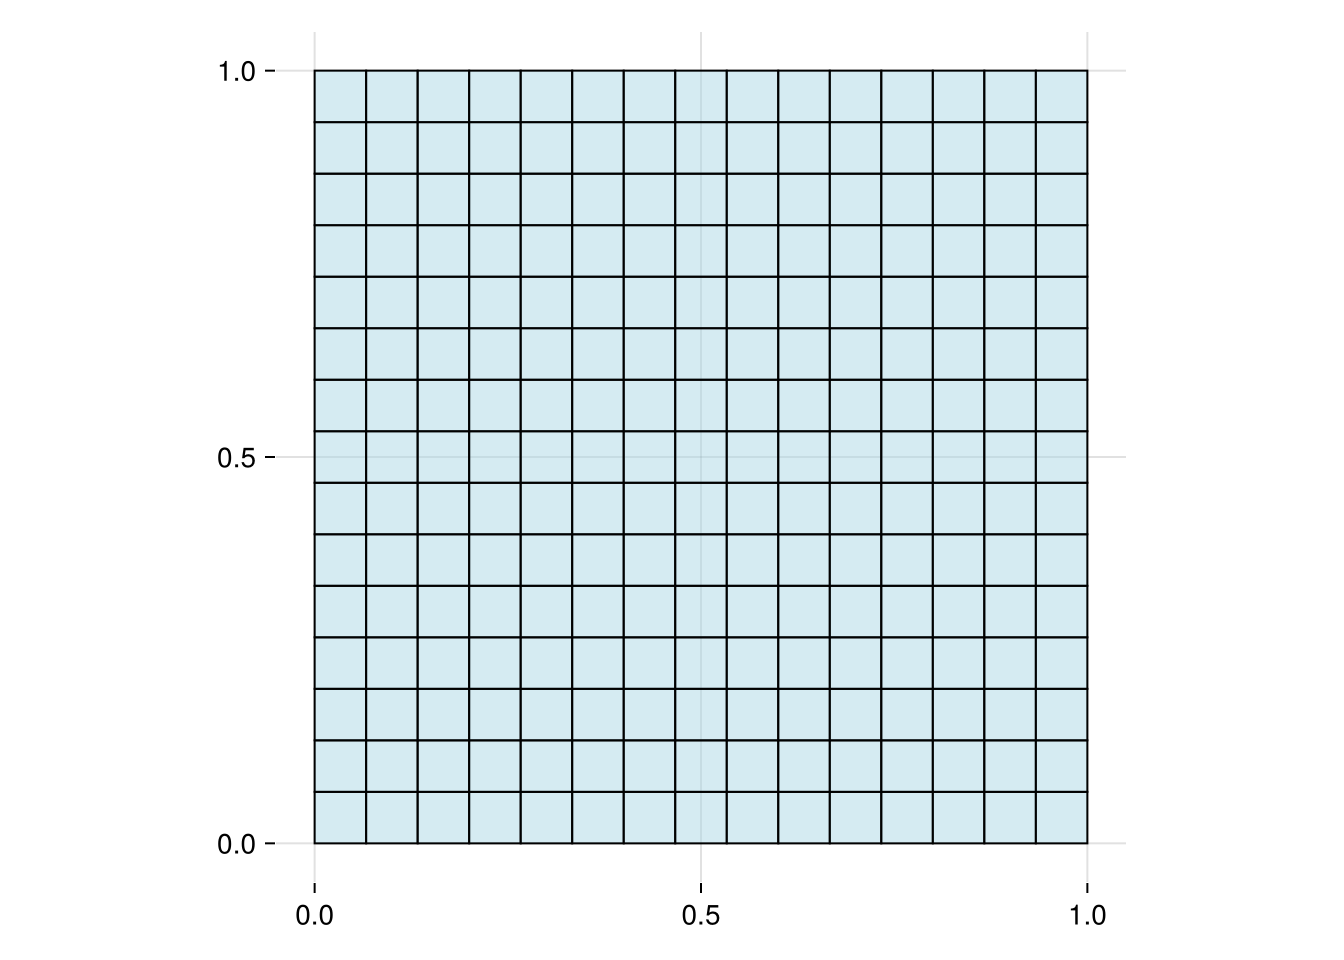

In [6]:
#| label: fig-mesh
#| fig-cap: 2D quadrilateral mesh

using CairoMakie
CairoMakie.activate!()
Makie.inline!(true)
fig = Figure()
ax = Axis(fig[1, 1], aspect=AxisAspect(1))
RayTraceHeatTransfer.plotMesh2D(ax, mesh1) # plot the mesh
# save("rectangle_mesh.png", fig) # Save the figure
fig